In [1]:
import torch
from torch import nn 
import matplotlib.pyplot as plt 
import pandas as pd 


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using device {device}')

using device cpu


In [3]:
from sklearn.datasets import make_regression  
train , target = make_regression(n_samples=100 , n_features=1 ,n_targets=1 , noise=10)

train_df = pd.DataFrame(train , columns=[f'feature {i}' for i in range(train.shape[1])])
target_df = pd.DataFrame(target , columns=['target'])

df = pd.concat([train_df,  target_df], axis=1)
df.head()


,feature 0,target
0,-0.706991,-63.892248
1,1.266428,120.065752
2,0.312468,28.926420
3,1.211682,84.332562
4,-0.151441,-26.110935


In [4]:
from sklearn.model_selection import train_test_split
import numpy as np  
xtrain, xtest , ytrain , ytest = train_test_split(train , target, test_size=0.2)
ytrain, ytest = np.expand_dims(ytrain , -1), np.expand_dims(ytest, -1)

In [5]:
xtrain.shape , xtest.shape , ytrain.shape , ytest.shape

((80, 1), (20, 1), (80, 1), (20, 1))

In [6]:
from sklearn.preprocessing import MinMaxScaler
def normalize_data(data, target):
    xscaler = MinMaxScaler()
    yscaler = MinMaxScaler()
    return xscaler.fit_transform(data), yscaler.fit_transform(target)

xtrain, ytrain = normalize_data(xtrain, ytrain)
xtest, ytest = normalize_data(xtest, ytest)


In [7]:
class LinearRegression(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1 , out_features=1)

    def forward(self, x:torch.tensor) ->torch.tensor: 
        return self.linear_layer(x)
    

model = LinearRegression()
model.state_dict() 
        

OrderedDict([('linear_layer.weight', tensor([[-0.3672]])),
             ('linear_layer.bias', tensor([-0.4864]))])

In [8]:
lossfn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters()  , lr=1e-2)

In [9]:
xtrain = torch.from_numpy(xtrain).float()
xtest  = torch.from_numpy(xtest).float()
ytrain = torch.from_numpy(ytrain).float()
ytest  = torch.from_numpy(ytest).float()


In [10]:
xtrain.shape , xtest.shape , ytrain.shape , ytest.shape

(torch.Size([80, 1]),
 torch.Size([20, 1]),
 torch.Size([80, 1]),
 torch.Size([20, 1]))

In [11]:
epoches = 400 
epochs_list = []
mae_list = [] 
unseen_mae_list = []



for i in range(epoches):
    model.train()
    ypred = model(xtrain)
    loss = lossfn(ypred , ytrain)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #testing 
    model.eval()
    with torch.inference_mode():
        unseen_pred = model(xtest)
        unseen_loss = lossfn(unseen_pred , ytest)

        if i % 10 == 0 :
            epochs_list.append(i)
            unseen_mae_list.append(unseen_loss.item())
            mae_list.append(loss.item())





## drawing performance chart

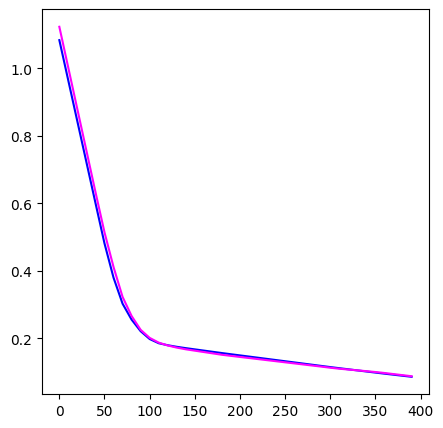

In [12]:
fig , axes = plt.subplots(figsize = (5, 5))
axes.plot(epochs_list , mae_list, color='blue')
axes.plot(epochs_list, unseen_mae_list, color='magenta')

In [13]:
ypred = model(xtest).detach()

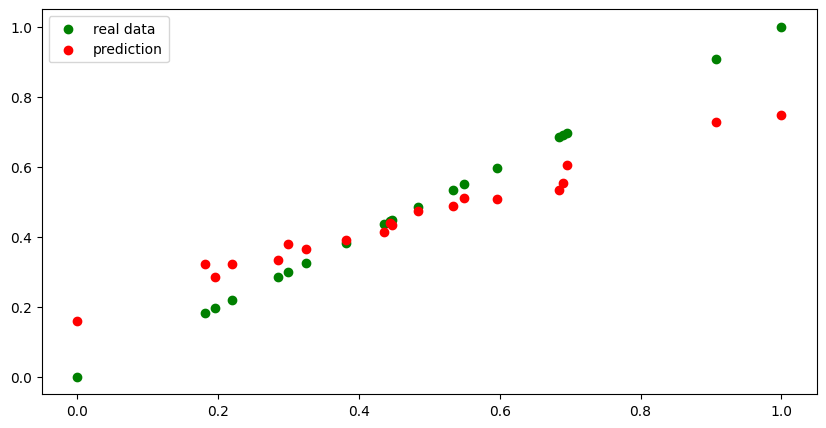

In [14]:
fig ,axes = plt.subplots(figsize = (10 ,5))
axes.scatter(ytest , ytest , color='green' , label ='real data')
axes.scatter(ytest , ypred , color='red' , label='prediction')
axes.legend()

In [15]:
import os 
os.makedirs(name='models' , exist_ok=True)
model_path = os.path.join('models/state_dict.pth')
torch.save(obj=model.state_dict() , f=model_path)